### Imports

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import HTML, clear_output, display
from time import sleep
import textwrap

### Object Class Definitions


In [2]:
class Car:
    """
        A class to represent a car.
        Attributes
        ----------
        lane : Lane
            the lane the car is on
        position : int
            the position of the car on the lane
        speed : int
            the speed of the car
        max_speed : int
            the maximum speed of the car
        slow_prob : float
            the probability of the car slowing down
        turn_prob : float
            the probability of the car turning at an intersection
        Methods
        -------
        look_ahead()
            Returns the distance to the next car or TrafficLight, or the distance to the end of the lane.
        move()
            Moves the car forward by one position.
    """
    def __init__(self, lane, position=0, speed=1, max_speed=5, slow_prob=0.05, turn_prob=0.075):
        assert isinstance(lane, Lane), "lane must be a Lane object."
        assert position >= 0, "Car position must be positive or zero."
        assert position < lane.length, "Car position must be less than the road size."
        assert speed >= 0, "Car speed must be positive or zero."
        assert max_speed > 0, "Car max speed must be positive."
        assert slow_prob > 0, "Car slow probability must be positive."
        assert slow_prob < 1, "Car slow probability must be less than 1."
        assert turn_prob > 0, "Car turn probability must be positive."
        assert turn_prob < 1, "Car turn probability must be less than 1."

        self.lane = lane
        self.sim = lane.sim
        self.position = position
        self.speed = speed
        self.max_speed = max_speed
        self.slow_prob = slow_prob
        self.turn_prob = turn_prob
        self.turn_at = None
        # Metrics
        self.entry_time = self.sim.t  # to be set when the car enters the grid
        self.waiting_time = 0  # to be incremented each time the car waits at a traffic light
        self.exit_time = 0  # to be set when the car exits the grid
        self.travel_time = 0  # to be calculated when the car exits the grid

    def look_ahead(self):
        """Returns the distance to the next car or TrafficLight, or the distance to the end of the lane."""
        for pos in range(self.position + 1, self.lane.length):
            # Check for car or red light
            if self.lane.road[pos] in [2,3]:
                # if self.turn_at is not None:
                    # self.sim.legends[-1] += f'{self} sees obstacle in {pos - self.position}\n'
                return pos - self.position
            # Check for intersection and turning
            elif self.turn_at is None and self.lane.road[pos] == 5 and random.random() < self.turn_prob:
                self.turn_at = pos  # set the turning position
                return pos - self.position
            # Check if turn approaching
            elif pos == self.turn_at:
                # self.sim.legends[-1] += f'{self} sees turn in {pos - self.position}\n'
                return pos - self.position
        # Return distance to end of lane
        return self.lane.length - self.position

    def move(self):
        """Updates the speed and position of the car."""
        # Find distance to next obstacle
        dist = self.look_ahead()

        # Check if turning position is within reach of current speed
        if self.turn_at is not None:
            if self.position + dist < self.lane.length and dist <= self.speed and self.lane.road[self.position + dist] == 5:
                # self.sim.legends[-1] += f'{self} slows down to turn\n'
                self.speed = dist # slow down to reach intersection
            elif self.position + dist < self.lane.length and dist > self.speed and self.lane.road[self.position + dist] == 5:
                # self.sim.legends[-1] += f'{self} speeds up to turn\n'
                self.speed = min(self.speed + 1, self.max_speed) # speed up to reach intersection

        # Remain in place if red light one position ahead
        if self.position + 1 < self.lane.length and self.lane.road[self.position + 1] in [2,3]:
            # if self.turn_at is not None:
                # self.sim.legends[-1] += f'{self} waits at red light\n'
            self.speed = 0
            # Metrics
            self.waiting_time += 1
        # Slow down if obstacle within reach of current speed
        elif dist <= self.speed or (dist == self.max_speed and self.max_speed - self.speed == 1):
            if self.turn_at != self.position + dist and self.position + dist < self.lane.length:
                # if self.turn_at is not None:
                    # self.sim.legends[-1] += f'{self} slows down for obstacle\n'
                self.speed = dist - 1
        # Keep constant speed if obstacle is just out of reach
        elif self.position + dist < self.lane.length and dist == self.speed + 1:
            if self.turn_at != self.position + dist:
                # if self.turn_at is not None:
                    # self.sim.legends[-1] += f'{self} keeps speed\n'
                pass
        # Speed up if possible
        elif self.turn_at is None:
            # if self.turn_at is not None:
                # self.sim.legends[-1] += f'{self} speeds up\n'
            self.speed = min(self.speed + 1, self.max_speed)
        # Randomly slow down
        if self.speed > 0 and random.random() < self.slow_prob:
            # self.sim.legends[-1] += f'{self} slows randomly\n'
            self.speed -= 1
        # if self.turn_at is not None:
            # self.sim.legends[-1] += f'{self}\n'

        # Move car
        self.position += self.speed
        # Check for end of road
        if self.position >= self.lane.length:
            # Metrics
            self.exit_time = self.sim.t
            self.travel_time = self.exit_time - self.entry_time
            self.lane.cars.remove(self)
            self.sim.completed_cars.append(self)
            # self.sim.legends[-1] += f'{self} exit: {len(self.sim.completed_cars)}\n' #---------------------------------LOG: car exit

        # Turn if at turning position
        if self.position == self.turn_at:
            self.lane.turning.append(self)
        # Update road
        if self.position < self.lane.length:
            self.lane.next_road[self.position] = 2

    def turn(self):
        """Turn the car onto a different lane."""
        # Reset turning position
        self.turn_at = None
        # Get destination lane
        other = self.lane.cross_idxs[self.position]
        # Determine new relative position on destination lane
        if other.direction in ['N', 'W']:
            other_pos = other.length - 1 - self.lane.position
        else:
            other_pos = self.lane.position
        # Remove car from old lane
        self.lane.cars.remove(self)
        # Add car to new lane
        self.lane = other
        self.lane.cars.append(self)
        # Update car position and speed
        self.position = other_pos
        self.speed = 1
        # self.sim.legends[-1] += f'-> {self} turned.\n'

    def __repr__(self):
        return f'Car(pos={self.position}, lane={self.lane}, speed={self.speed}, turn_at={self.turn_at})'

In [3]:
class TrafficLight:
    """
        A class used to represent a traffic light.

        Attributes
        ----------
        state : int
            The state of the traffic light (0 = red, 1 = green)
        duration : int
            The duration of the traffic light in time steps
        Methods
        -------
        update()
            Updates the traffic light state.
    """
    def __init__(self, lane, position, duration=(25,25)):
        assert isinstance(lane, Lane), "lane must be a Lane object."
        assert position >= 0, "Traffic light position must be positive."
        assert position < lane.length, "Traffic light position must be less than the road size."
        assert len(duration) == 2, "Traffic light duration must be a tuple of length 2."
        assert duration[0] > 0, "Traffic light red duration must be positive."
        assert duration[1] > 0, "Traffic light green duration must be positive."

        self.lane = lane
        self.position = position
        self.state = lane.road[position]
        self.duration = duration
        self.counter = duration[self.state-3]
        self.waiting_cars = 0

    def update(self):
        """Updates the traffic light state."""
        # Check for cars waiting at red light
        self.waiting_cars = 0
        if self.state == 3:
            for i in self.lane.road[self.position-1::-1]:
                if i == 2:
                    self.waiting_cars += 1
                else:
                    break
        # Update traffic light state
        self.counter -= 1
        if self.counter == 0:
            self.state = self.state + 1 if self.state < 4 else self.state - 1
            self.counter = self.duration[self.state-3]
            # self.lane.sim.legends[-1] += f'{self}\n'
        self.lane.next_road[self.position] = self.state
    
    def __repr__(self):
        return f'TrafficLight(pos={self.position}, lane={self.lane}, state={self.state}, dur={self.duration})'

In [4]:
class Lane:
    """
        A class used to represent a lane. A lane is a one-dimensional road with cars and traffic lights.
        This class stores a reference to a row or column of the simulation grid as a numpy array.
        We use store the state of the lane as a numpy array of integers, where 0 represents an empty cell, 
        1 represents a car, and 2 and 3 represent traffic lights (red and green, respectively).
        Attributes
        ----------
        sim : TrafficSimulation
            The traffic simulation the lane is part of.
        road : np.ndarray
            The state of the lane as a numpy array of integers.
        next_road : np.ndarray
            The next state of the lane as a numpy array of integers.
        traffic_lights : list
            A list of traffic lights on the lane.
        cars : list
            A list of cars on the lane.
        length : int
            The length of the lane.
        entry_rate : float
            The rate at which cars are inserted into the lane.
        
        Methods
        ------- 
        update()
            Updates the lane by moving all cars forward based on their speed.
        commit()
            Commits the changes to the lane.
    """
    def __init__(self, sim, subarray, position, direction, entry_rate=0.1):
        assert isinstance(sim, TrafficSimulation), "sim must be a TrafficSimulation object."
        assert isinstance(subarray, np.ndarray), "subarray must be a numpy array."
        assert len(subarray.shape) == 1, "subarray must be a one-dimensional array."
        assert subarray.shape[0] == sim.size, "subarray must have the same length as the simulation grid."
        assert entry_rate >= 0, "entry_rate must be positive or zero."
        assert entry_rate <= 1, "entry_rate must be less than or equal to 1."

        self.sim = sim
        self.position = position
        self.direction = direction
        self.road = subarray
        self.length = len(subarray)
        self.entry_rate = entry_rate
        self.next_road = np.ones_like(subarray)
        self.traffic_lights = []
        self.max_waiting_cars = 0
        self.cars = []
        self.turning = []
        self.cross_idxs = {}

    def pre_update(self):
        """Sets the appropriate turning cars to their new lanes, removes completed cars, and updates the traffic lights."""
        # Assign turning cars to their new lanes
        for car in self.turning:
            # self.sim.legends[-1] += f'{car} turning.\n'
            car.turn()
        # Reset turning cars
        self.turning = []
        # Update and visualize traffic lights
        for traffic_light in self.traffic_lights:
            traffic_light.update()
            # Metrics
            self.max_waiting_cars = max(self.max_waiting_cars, traffic_light.waiting_cars)

    def update(self):
        """Updates the lane by moving all cars forward based on their speed."""
        # Move cars, iterate backwards to avoid index errors
        for i in range(len(self.cars)-1, -1, -1):
            car = self.cars[i]
            car.move()
        # Visualize intersections
        for idx, cross_lane in self.cross_idxs.items():
            lane_idx = self.position if cross_lane.direction in ['E', 'S'] else self.length-1-self.position
            # if self.next_road[idx] == 2 and cross_lane.next_road[lane_idx] == 2:
            #     self.sim.legends[-1] += f'!! Collision on lane {self} at position {idx}\n' # --------------------------------- LOG: Collision
            if self.next_road[idx] != 2 and cross_lane.next_road[lane_idx] == 2:
                self.next_road[idx] = 2
            elif self.next_road[idx] == 2 and cross_lane.next_road[lane_idx] != 2:
                cross_lane.next_road[lane_idx] = 2
            elif self.next_road[idx] in [1,5] and cross_lane.next_road[lane_idx] in[1,5]:
                cross_lane.next_road[lane_idx] = 5

        # Add new cars
        if random.random() < self.entry_rate and self.road[0] == 1:
            self.next_road[0] = 2
            self.cars.append(Car(self))
            # Metrics
            self.sim.all_cars.append(self.cars[-1])

        # Remove cars that have reached the end of the lane
        self.cars = [car for car in self.cars if car not in self.sim.completed_cars]

    def commit(self):
        """Commits the changes to the lane."""
        self.road[:] = self.next_road[:]
        self.next_road[:] = 1
        self.next_road[list(self.cross_idxs.keys())] = 5

    def emojize(self, t=-1):
        if t >= 0:
            if self.direction == 'N':
                road = self.sim.history[t][self.length::-1,self.position]
            elif self.direction == 'S':
                road = self.sim.history[t][:,self.position]
            elif self.direction == 'E':
                road = self.sim.history[t][self.position,:]
            elif self.direction == 'W':
                road = self.sim.history[t][self.position,self.length-1::-1]
        else:
            road = self.road
        output = ''
        for i in range(self.length):
            if road[i] == 1:
                # black square
                output += '⬛'
            elif road[i] == 2:
                output += '🚙'
            elif road[i] == 3:
                output += '🔴'
            elif road[i] == 4:
                output += '🟢'
            elif road[i] == 5:
                output += '🔳'
        return output

    def __repr__(self):
        return f'Lane(dir={self.direction}, pos={self.position}, entry_r={self.entry_rate})'    

### Simulation Class

In [49]:
class TrafficSimulation():
    """
        A class used to represent a traffic simulation. A traffic simulation is a two-dimensional grid where some rows and columns are lanes.

        Attributes
        ----------
        size : int
            The size of the simulation grid.
        grid : numpy.ndarray
            The simulation grid containing the lanes, cars, and traffic lights.
        traffic_lights : numpy.ndarray
            The traffic lights of the simulation.
        history : list
            The history of the simulation.
        cmap : matplotlib.colors.ListedColormap
            The color map used to plot the simulation.

        Methods
        -------
        run_simulation(timesteps)
            Runs the traffic simulation for the given number of timesteps.
        plot_simulation()
            Plots and saves the traffic simulation.
            Outputs a matplotlib animation if anim=True.
    """
    def __init__(self, size=50):
        assert size >= 4, "size must be at least 4."

        self.size = size
        self.schema = None
        self.grid = np.full((self.size, self.size), 0)
        self.v_idxs = []
        self.h_idxs = []
        self.lanes = []
        self.history = []
        self.legends = []
        self.cmap = ListedColormap(['ivory','darkgrey', 'royalblue', 'orangered', 'limegreen', 'dimgrey']) # Empty, Car, Traffic Light Off, Traffic Light On
        # Metrics
        self.t = 0 # current timestep
        self.total_car_density = 0 # total car density over all timesteps
        self.max_car_density = 0 # maximum car density over all timesteps
        self.max_waiting_cars = 0 # maximum number of waiting cars at a traffic light over all timesteps
        self.total_waiting_time = 0 # total waiting time over all timesteps
        self.total_travel_time = 0 # total travel time over all timesteps
        self.all_cars = [] # all cars that enter the simulation over all timesteps
        self.completed_cars = [] # all cars that exit the simulation over all timesteps


    def add_lane(self, direction, position, entry_rate=0.1):
        """Adds a lane to the simulation grid."""
        assert direction in ['N', 'S', 'E', 'W'], "direction must be one of 'N', 'S', 'E', 'W'."
        assert position >= 0, "position must be positive or zero."
        assert position < self.size, "position must be less than the size of the simulation grid."

        for lane in self.lanes:
            if lane.direction == direction and lane.position == position:
                return
        
        if direction == 'N':
            subarray = self.grid[self.size-1::-1, position]
            self.v_idxs.append(position)
        elif direction == 'S':
            subarray = self.grid[:, position]
            self.v_idxs.append(position)
        elif direction == 'E':
            subarray = self.grid[position, :]
            self.h_idxs.append(position)
        elif direction == 'W':
            subarray = self.grid[position, self.size-1::-1]
            self.h_idxs.append(position)
        else:
            raise ValueError("direction must be one of 'N', 'S', 'E', 'W'.")
        subarray[:] = 1
        new_lane = Lane(self, subarray, position, direction)
        self.lanes.append(new_lane)
    
    def assign_entry_rate(self, lanes, entry_rate):
        """Assigns a given entry rate to the given lanes."""
        assert isinstance(lanes, dict), "lanes must be a dict."
        for direction, positions in lanes.items():
            for position in positions:
                assert any(direction == lane.direction and position == lane.position for lane in self.lanes), "lane must be a lane in the simulation."
        assert isinstance(entry_rate, float), "entry_rate must be a float."
        assert entry_rate >= 0, "entry_rate must be positive or zero."
        assert entry_rate <= 1, "entry_rate must be less than or equal to 1."

        for direction, positions in lanes.items():
            for position in positions:
                for lane in self.lanes:
                    if direction == lane.direction and position == lane.position:
                        lane.entry_rate = entry_rate

    def assemble_layout(self):
        """Assembles a layout dictionary from the lanes that have been added to the simulation."""
        assert len(self.lanes) > 0, "if no layout is provided to setup(), lanes must be added first using add_lane(direction, position)."
        layout = {'N': [], 'S': [], 'E': [], 'W': []}
        for lane in self.lanes:
            layout[lane.direction].append(lane.position)
        return layout

    def setup(self, layout=None, priority={'N':1, 'S':1, 'E':1, 'W':1}, schema='default', default_entry_rate=0.1):
        """Sets up the simulation based on the given layout."""
        if layout is None:
            layout = self.assemble_layout()
        assert isinstance(layout, dict), "layout must be a dictionary."
        assert len(layout) > 0, "layout must not be empty."
        assert all(direction in ['N', 'S', 'E', 'W'] for direction in layout.keys()), "directions must be one of 'N', 'S', 'E', 'W'."
        assert isinstance(priority, dict), "priority must be a dictionary."
        assert len(priority) == 4, "priority must have 4 keys."
        assert all(direction in ['N', 'S', 'E', 'W'] for direction in priority.keys()), "priority keys must be one of 'N', 'S', 'E', 'W'."
        assert all(isinstance(p, int) for p in priority.values()), "priority values must be integers."
        assert all(p > 0 for p in priority.values()), "priority values must be positive."
        assert all(p <= 4 for p in priority.values()), "priority values must be less than or equal to 4."
        assert all(isinstance(idxs, list) for idxs in layout.values()), "lane indices must be lists."
        assert all(isinstance(idx, int) for idxs in layout.values() for idx in idxs), "lane indices must be integers."
        assert all(idx >= 0 for idxs in layout.values() for idx in idxs), "lane indices must be positive or zero."
        assert all(idx < self.size for idxs in layout.values() for idx in idxs), "lane indices must be less than the size of the simulation grid."
        assert isinstance(default_entry_rate, float), "default_entry_rate must be a float."
        assert default_entry_rate >= 0, "default_entry_rate must be positive or zero."
        assert default_entry_rate <= 1, "default_entry_rate must be less than or equal to 1."
        assert schema in ['default', 'staggered'], "schema must be one of 'default', 'staggered'."
        if schema == 'staggered':
        #     assert len(layout['N'])+len(layout['S']) <= 2, "staggered schema requires no more than 2 parallel lanes."
        #     assert len(layout['E'])+len(layout['W']) <= 2, "staggered schema requires no more than 2 parallel lanes."
            assert len(set(priority.values())) >= 2, "staggered schema requires at least 2 priority differences."
        def check_min_diff(lst):
            lst = sorted(lst)
            return min(b - a for a, b in zip(lst[:-1], lst[1:])) > 2
        if len(layout['N'])+len(layout['S']) > 1: assert check_min_diff(layout['N']+layout['S']), "parallel lanes must have at least 2 cells in between."
        if len(layout['E'])+len(layout['W']) > 1: assert check_min_diff(layout['E']+layout['W']), "parallel lanes must have at least 2 cells in between."
        
        self.schema = schema
        # Add lanes
        for direction, idxs in layout.items():
            for idx in idxs:
                self.add_lane(direction, idx, entry_rate=default_entry_rate)
        # Sort lane indices
        self.lanes.sort(key=lambda lane: lane.position)
        self.v_idxs.sort()
        self.h_idxs.sort()
        # Add intersections and traffic lights
        for i in self.h_idxs:
            for j in self.v_idxs:
                self.grid[i,j] = 5 # Intersection
                lanes = self.get_lanes(i, j)
                dirs = [lane.direction for lane in lanes]
                states = {}
                if 'N' in dirs:
                    self.get_lanes(i, j)[dirs.index('N')].cross_idxs[self.size-1-i] = self.get_lanes(i, j)[(dirs.index('N')+1)%2]
                    states['N'] = [self.config_traffic_lights(i, j, lanes[dirs.index('N')]), (i+1,j)]
                elif 'S' in dirs:
                    self.get_lanes(i, j)[dirs.index('S')].cross_idxs[i] = self.get_lanes(i, j)[(dirs.index('S')+1)%2]
                    states['S'] = [self.config_traffic_lights(i, j, lanes[dirs.index('S')]), (i-1,j)]
                if 'E' in dirs:
                    self.get_lanes(i, j)[dirs.index('E')].cross_idxs[j] = self.get_lanes(i, j)[(dirs.index('E')+1)%2]
                    states['E'] = [self.config_traffic_lights(i, j, lanes[dirs.index('E')]), (i,j-1)]
                elif 'W' in dirs:
                    self.get_lanes(i, j)[dirs.index('W')].cross_idxs[self.size-1-j] = self.get_lanes(i, j)[(dirs.index('W')+1)%2]
                    states['W'] = [self.config_traffic_lights(i, j, lanes[dirs.index('W')]), (i,j+1)]
                # resolve conflicts by priority for staggered schema
                if self.schema == 'staggered' and list(states.values())[0][0] == list(states.values())[1][0]:
                    loser = min(states, key=lambda d: priority[d])
                    self.grid[states[loser][1]] = 4 if states[loser][0] == 3 else 3
                    # print(f'{states} conflict!\n{loser} loses by priority {priority} and becomes {self.grid[states[loser][1]]}')

        # Assign traffic lights to lanes
        for lane in self.lanes:
            # print(lane, lane.cross_idxs, end=' ')
            for idx in range(lane.length):
                val = lane.road[idx]
                if val in [3,4]:
                    cross_lane = lane.cross_idxs[idx+1]
                    dur = (priority[cross_lane.direction]*10, priority[lane.direction]*10)
                    # print(dur, end=' ')
                    lane.traffic_lights.append(TrafficLight(lane, idx, dur))
            # print()

    def config_traffic_lights(self, i, j, lane):
        """Configures the traffic lights at the given coordinates."""
        # Traffic lights schema 1: default, traffic lights along each lane start in the same state
        if self.schema == 'default':
            if lane.direction == 'N':
                self.grid[i+1,j] = 3
            elif lane.direction == 'S':
                self.grid[i-1,j] = 3
            elif lane.direction == 'E':
                self.grid[i,j-1] = 4
            elif lane.direction == 'W':
                self.grid[i,j+1] = 4
            return 3 if lane.direction in ['N', 'S'] else 4
        # Traffic lights schema 2: staggered, traffic lights along each lane start in alternating states
        # conflicts resolved by priority in setup() using returned state
        elif self.schema == 'staggered':
            if lane.direction == 'N':
                state = 3 + self.h_idxs[::-1].index(i) % 2
                self.grid[i+1,j] = state
            elif lane.direction == 'S':
                state = 3 + self.h_idxs.index(i) % 2
                self.grid[i-1,j] = state
            elif lane.direction == 'E':
                state = 3 + self.v_idxs.index(j) % 2
                self.grid[i,j-1] = state
            elif lane.direction == 'W':
                state = 3 + self.v_idxs[::-1].index(j) % 2
                self.grid[i,j+1] = state
            return state

    def get_lanes(self, x, y):
        """Returns the lanes that intersect at the given coordinates."""
        return [lane for lane in self.lanes if lane.direction in ['E', 'W'] and lane.position == x or lane.direction in ['N', 'S'] and lane.position == y]

    def run_simulation(self, timesteps=100, draw=False):
        """Runs the traffic simulation for the given number of timesteps."""
        for t in range(timesteps):
            # Enable runnning log
            self.legends.append('')
            # Add the current state of the simulation to the history
            self.history.append(self.grid.copy())

            # Time step
            self.t = t
            # Calculate car density for this timestep
            car_density = np.sum(self.grid == 2) / (self.size*len(self.lanes))
            # Update total and max car density
            self.total_car_density += car_density
            self.max_car_density = max(car_density, self.max_car_density)
            
            # self.legends[-1] += f'{len(self.all_cars), len(self.completed_cars)}\n'
            # Pre-update lanes with turning cars and traffic lights
            for lane in self.lanes:
                lane.pre_update()
            # Update lanes with moving cars
            for lane in self.lanes:
                lane.update()
            for lane in self.lanes:
                lane.commit()
            # Wrap the log for this timestep
            if self.legends[-1] != '':
                self.legends[-1] = f'>{t}:\n'+self.legends[-1]+'\n\n'
            
            # Draw the simulation at each timestep
            if draw:
                print(self.emojize())
                sleep(0.2)
                clear_output(wait=True)
        
        # Metrics - Totals
        self.max_waiting_cars = max(lane.max_waiting_cars for lane in self.lanes)
        self.total_waiting_time = sum(car.waiting_time for car in self.all_cars) / sum(light.duration[0] for lane in self.lanes for light in lane.traffic_lights)
        self.total_travel_time = sum(car.travel_time for car in self.completed_cars) / sum(light.duration[0] for lane in self.lanes for light in lane.traffic_lights)

        # Metrics - Convert totals to averages
        self.avg_car_density = self.total_car_density / timesteps
        self.avg_waiting_time = self.total_waiting_time / len(self.all_cars) if len(self.all_cars) > 0 else 0
        self.avg_travel_time = self.total_travel_time / len(self.completed_cars) if len(self.completed_cars) > 0 else 0

        # Convert history to numpy array
        self.history = np.array(self.history.copy())

    def plot_simulation(self, pic=True, timestep=-1, anim=0, logs=False, save=True, filename='traffic_simulation', interval=200):
        """Plots and saves the traffic simulation."""
        assert timestep < len(self.history), "timestep must be less than the number of timesteps in the simulation."
        try: bool(pic)
        except ValueError as e: raise AssertionError('pic must be interpretable as a boolean') from e
        try: bool(logs)
        except ValueError as e: raise AssertionError('logs must be interpretable as a boolean') from e
        try: bool(save)
        except ValueError as e: raise AssertionError('save must be interpretable as a boolean') from e
        assert anim in [0,1,2], "anim must be one of 0, 1, 2."
        assert isinstance(filename, str), "filename must be a string."
        assert interval > 0, "interval must be positive."

        if timestep == -1:
            timestep = len(self.history)-1
        # Create figure and axes
        if logs:
            def wrap_text(text, width):
                """Wraps text to the given width."""
                lines = text.split('\n')  # split the text into lines
                wrapped_lines = [textwrap.fill(line, width) for line in lines]  # wrap each line individually
                return '\n'.join(wrapped_lines)  # join the lines back together
            # If logs are enabled, create two subplots
            fig, (ax, axLog) = plt.subplots(1, 2, figsize=(12, 6))
            axLog.set_title('Log')
            axLog.set_xticks([]) # remove ticks and labels
            axLog.set_yticks([])
            axLog.set_facecolor('black') # set background color
            textLog = axLog.text(0.02, 0.0, '', horizontalalignment='left', # create and style text object
                                                verticalalignment='bottom',
                                                fontsize=8,
                                                fontfamily='monospace',
                                                fontweight='bold',
                                                color='white')
        else:
            # If logs are disabled, create one subplot
            fig, ax = plt.subplots(figsize=(6, 6))
        # Set title and adjust spacing for main simulation subplot 
        ax.set_title('2D Traffic Simulation') 
        # plt.subplots_adjust(left=0.1, wspace=0.5)
        
        text = ax.text(0.01, 0.01, '', transform=ax.transAxes, fontsize=8, fontfamily='monospace') # create and style text object for frame counter
        
        # Assemble array of labels for the lanes based on their direction
        v_directions = [lane.direction for lane in self.lanes if lane.direction in ['N', 'S']]
        h_directions = [lane.direction for lane in self.lanes if lane.direction in ['E', 'W']]
        v_labels = ['⬆' if _ == 'N' else '⬇' for _ in v_directions]
        for i in range(len(self.v_idxs)):       # add lane index to label
            v_labels[i] += f' {self.v_idxs[i]}' # comment out to keep directions only
        h_labels = ['⬅' if _ == 'W' else '➡' for _ in h_directions]
        for i in range(len(self.h_idxs)):       # add lane index to label
            h_labels[i] += f' {self.h_idxs[i]}' # comment out to keep directions only

        # Set ticks and labels
        ax.set_xticks(self.v_idxs)
        ax.set_xticklabels(v_labels)
        ax.set_yticks(self.h_idxs)
        ax.set_yticklabels(h_labels)

        # Set ticks on both sides of axes (clears up confusion about which direction the lanes are going)
        ax.tick_params(right= True, top=True, labelright=True, labeltop=True)
        fig.tight_layout()

        if pic:
            # Plot the last state of the simulation
            im = ax.imshow(self.history[timestep], cmap=self.cmap, vmin=0, vmax=5, interpolation='none')
            text.set_text(f'{timestep}') # include the timestep of the selected plot
            plt.show()
            if save:
                fig.savefig(f'{filename}.png', dpi=300)

        if anim:
            plt.rcParams['animation.embed_limit'] = round(len(self.history)*0.2)
            # Plot the first state of the simulation
            im = ax.imshow(self.history[0], cmap=self.cmap, vmin=0, vmax=5, interpolation='none')

            plt.close()
            # Define animation function
            def animate(i):
                # Update the image
                im.set_array(self.history[i])
                text.set_text(f'{i}')  # update the counter
                if logs:
                    num_lines = 10  # number of log lines to display
                    non_empty_legends = [legend for legend in self.legends[:i+1] if legend != '']
                    recent_legends = non_empty_legends[-num_lines:]
                    textLog.set_text(wrap_text(''.join(recent_legends), 72))
                return im, text
            # Create the animation
            ani = animation.FuncAnimation(fig, animate, frames=len(self.history), interval=interval)
            # Display the animation
            if anim == 1:
                display(HTML(ani.to_jshtml(default_mode='once')))
            if anim == 2:
                # display animation as html5 video without looping
                display(HTML(ani.to_html5_video().replace('loop', '')))
            # Save the animation
            if save:
                ani.save(f'{filename}.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
            

    def emojize(self, t=-1):
        """Returns a string representation of the simulation grid using emojis."""
        if t >= 0:
            grid = self.history[t]
        else:
            grid = self.grid
        output = ''
        for i in range(self.size):
            for j in range(self.size):
                if grid[i][j] == 1:
                    if i == self.size-1 and self.get_lanes(i, j)[0].direction == 'N':
                        output += '⏫'
                    elif i == 0 and self.get_lanes(i, j)[0].direction == 'S':
                        output += '⏬'
                    elif j == self.size-1 and self.get_lanes(i, j)[0].direction == 'W':
                        output += '⏪'
                    elif j == 0 and self.get_lanes(i, j)[0].direction == 'E':
                        output += '⏩'
                    else:
                        output += '⬛'
                elif grid[i][j] == 2:
                    output += '🚙'
                elif grid[i][j] == 3:
                    output += '🔴'
                elif grid[i][j] == 4:
                    output += '🟢'
                elif grid[i][j] == 5:
                    output += '🔳'
                else:
                    output += '⬜'
            output += '\n'
        return output

    def __str__(self):
        return self.emojize()

### Testing Functionality

In [169]:
# random.seed(69)
# experiment = {'N': [20, 14],
#               'S': [9],
#               'E': [10, 15],
#               'W': [23, 6]}
experiment = {'N': [20,5],
            'S': [12],
            'E': [17],
            'W': [13]}

sim = TrafficSimulation(size=30)
# sim.add_lane('N', 20)
# sim.add_lane('S', 10, 0.7)
# sim.add_lane('E', 5)
# sim.setup(experiment, priority={'N':2, 'S':2, 'E':2, 'W':2}, schema='default', default_entry_rate=0.1)
sim.setup(experiment, priority={'N':3, 'S':3, 'E':1, 'W':1}, schema='default', default_entry_rate=0.1)
sim.assign_entry_rate(lanes={'N':[5, 20], 'S':[12]}, entry_rate=0.7)
sim.assign_entry_rate(lanes={'E':[17], 'W':[13]}, entry_rate=0.02)
# print(sim)
sim.run_simulation(timesteps=500, draw=0)
print(f'avg_car_density: {sim.avg_car_density}')
print(f'max_car_density: {sim.max_car_density}')
print(f'max_waiting_cars: {sim.max_waiting_cars}')
print(f'avg_waiting_time: {sim.avg_waiting_time}')
print(f'avg_travel_time: {sim.avg_travel_time}')

avg_car_density: 0.13093333333333348
max_car_density: 0.19333333333333333
max_waiting_cars: 6
avg_waiting_time: 0.020164041994750657
avg_travel_time: 0.06553649237472767


In [171]:
sim.plot_simulation(pic=0, timestep=-1, anim=2, logs=0, save=1, filename='experiment', interval=100)

## Model 

### Assumptions

1. **Grid-based World:** The simulation assumes the world is a grid of a certain size. This simplifies complex real-world road networks into a more manageable structure for simulation. 

2. **Unidirectional Lanes:** All lanes are unidirectional, and their direction is one of north (N), south (S), east (E), or west (W). This means that all traffic within a lane moves in a single direction.

3. **Uniform Car Behavior:** All cars follow the same set of rules for driving and turning. They obey traffic lights, and do not take actions like overtaking or varying speed. This makes behavior predictable, but may not reflect the variety of behaviors observed in real-world drivers.

4. **Uniform Traffic Light Behavior:** Traffic lights operate on a fixed cycle, alternating between "on" and "off" states. This does not take into account advanced traffic light control systems that dynamically adjust timings based on traffic conditions.

5. **Fixed Lane Positions:** Once lanes are added to the grid, their positions are fixed and cannot be changed. This is a simplification, as in the real world, lane configurations can be adjusted over time to improve traffic flow.

6. **Minimum Distance between Parallel Lanes:** The model assumes a minimum distance of 2 cells between parallel lanes. This assumption may not accurately reflect all real-world scenarios, where distances between lanes can vary.

### Rules

1. **Traffic Light Rules:** Traffic lights follow a pre-determined green-red cycle, based on the given priorities for each direction. Cars cannot move forward when the traffic light in front of them is red.

2. **Car Movement:** Cars move forward along their lanes each timestep, provided the next cell in the lane is empty and the traffic light (if present) is green. Cars have a fixed probability to turn at an upcoming intersection along their lane, if they decide to do so, they adjust their speed to reach the target intersection once it is within reach.

3. **Intersections:** Intersections are points where lanes cross each other. Cars can turn at intersections with a pre-determined probability; they spend one timestep positioned at the intersection in order to turn appropriately.

4. **Conflict Resolution:** In a 'staggered' schema setup, if two traffic lights at an intersection are configured to be in the same state, the traffic light associated with the direction having lower priority is switched to the alternate state to avoid conflicts.

### Parameters

1. **Grid Size:** The size of the grid world can be set at the start of the simulation. This represents the total area available for laying out lanes and intersections.

2. **Lane Directions and Positions:** These are specified when lanes are added to the grid. The directions and positions of lanes form the basic layout of the road network in the simulation.

3. **Traffic Light Priorities:** These can be set for each direction (N, S, E, W) when setting up the simulation. Higher priority implies a longer duration of the 'on' state of the traffic light.

4. **Traffic Light Schema:** This can be set as 'default' or 'staggered'. In the 'default' schema, traffic lights along each lane start in the same state. In the 'staggered' schema, they start in alternating states.

5. **Timesteps:** The total duration of the simulation is controlled by the number of timesteps. Each timestep represents a unit of time during which cars move and traffic lights change state.

The Traffic Simulation model represents a simplification of real-world traffic, focusing on capturing the core dynamics of

 traffic flow. This model can be expanded and refined by incorporating more complex behaviors and controls, as well as varying the parameters and assumptions based on specific contexts. It serves as a foundational framework for understanding and studying traffic behavior.

## Experiments & Analysis

In [8]:
def trial(size, timesteps, layout, priority, schema, entry_rate):
    """Runs a single trial run of the simulation. Returns a dictionary of metrics."""
    sim = TrafficSimulation(size=size)
    sim.setup(layout=layout, priority=priority, schema=schema, default_entry_rate=entry_rate)
    sim.run_simulation(timesteps=timesteps, draw=0)
    return sim, {
        'average_car_density': sim.avg_car_density,
        'maximum_car_density': sim.max_car_density,
        'maximum_waiting_cars': sim.max_waiting_cars,
        'average_waiting_time': sim.avg_waiting_time,
        'average_travel_time': sim.avg_travel_time,
    }

def run_experiment(n_runs, size, timesteps, layout, priority, schema, entry_rate, alpha=0.05):
    """Runs the simulation n_runs times and returns a dictionary of metrics alongside 
    their respective empirical mean and confidence intervals."""
    sims = []
    # Lists to store the results of each run
    avg_car_densities = []
    max_car_densities = []
    max_waiting_cars = []
    avg_waiting_times = []
    avg_travel_times = []

    # Run the simulation n_runs times
    for _ in range(n_runs):
        sim, results = trial(size, timesteps, layout, priority, schema, entry_rate)
        sims.append(sim)
        avg_car_densities.append(results['average_car_density'])
        max_car_densities.append(results['maximum_car_density'])
        max_waiting_cars.append(results['maximum_waiting_cars'])
        avg_waiting_times.append(results['average_waiting_time'])
        avg_travel_times.append(results['average_travel_time'])

    # Convert lists to numpy arrays for easier manipulation
    avg_car_densities = np.array(avg_car_densities)
    max_car_densities = np.array(max_car_densities)
    max_waiting_cars = np.array(max_waiting_cars)
    avg_waiting_times = np.array(avg_waiting_times)
    avg_travel_times = np.array(avg_travel_times)

    # Compute means
    mean_avg_car_density = np.mean(avg_car_densities)
    mean_max_car_density = np.mean(max_car_densities)
    mean_max_waiting_cars = np.mean(max_waiting_cars)
    mean_avg_waiting_time = np.mean(avg_waiting_times)
    mean_avg_travel_time = np.mean(avg_travel_times)

    # Compute confidence intervals
    ci_avg_car_density = sts.t.interval(alpha, n_runs-1, loc=mean_avg_car_density, scale=sts.sem(avg_car_densities))
    ci_max_car_density = sts.t.interval(alpha, n_runs-1, loc=mean_max_car_density, scale=sts.sem(max_car_densities))
    ci_max_waiting_cars = sts.t.interval(alpha, n_runs-1, loc=mean_max_waiting_cars, scale=sts.sem(max_waiting_cars))
    ci_avg_waiting_time = sts.t.interval(alpha, n_runs-1, loc=mean_avg_waiting_time, scale=sts.sem(avg_waiting_times))
    ci_avg_travel_time = sts.t.interval(alpha, n_runs-1, loc=mean_avg_travel_time, scale=sts.sem(avg_travel_times))

    # Return results
    return sims, {
        'average_car_density': (mean_avg_car_density, ci_avg_car_density),
        'maximum_car_density': (mean_max_car_density, ci_max_car_density),
        'maximum_waiting_cars': (mean_max_waiting_cars, ci_max_waiting_cars),
        'average_waiting_time': (mean_avg_waiting_time, ci_avg_waiting_time),
        'average_travel_time': (mean_avg_travel_time, ci_avg_travel_time),
    }

In [162]:
def plot_histogram(data, metric_name):
    plt.hist(data, bins=30)
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {metric_name} across simulation runs')
    plt.show()

### Strategies and Evaluation



#### Layout 1: Horizontally symmetrical traffic load

In [136]:
# The layout establishes the number of lanes, their positions, and their directions so should remain constant for each experiment
layout1 = {'N': [30,10],
        'S': [20,40],
        'E': [15],
        'W': [35]}
# Lists of values to test for each parameter
priority_values = [{'N':2, 'S':2, 'E':2, 'W':2}, # Equal priority for all lanes
                   {'N':3, 'S':3, 'E':1, 'W':1}, # Prioritize vertical lanes
                   {'N':1, 'S':1, 'E':3, 'W':3}, # Prioritize horizontal lanes
                   {'N':3, 'S':4, 'E':1, 'W':1}, # Prioritize central southbound lanes, horizontal lanes have lowest priority
                   {'N':1, 'S':4, 'E':3, 'W':3}] # Prioritize central southbound lanes, then horizontal lanes
schema_values = ['default', 'staggered']
entry_rate_values = [0.1, 0.3, 0.6]

# Initialize empty lists for each metric and parameter
avg_car_density = []
max_car_density = []
max_waiting_cars = []
avg_waiting_time = []
avg_travel_time = []
priority = []
schema = []
entry_rate = []

# Run the each experiment, appending the metrics and parameters to the lists
for p in priority_values:
    for s in schema_values:
        if s == 'staggered' and len(set(p.values())) == 1:
            continue
        for e in entry_rate_values:
            _, results = run_experiment(n_runs=100, size=50, timesteps=400, layout=layout1, priority=p, schema=s, entry_rate=e)
            avg_car_density.append(results['average_car_density'])
            max_car_density.append(results['maximum_car_density'])
            max_waiting_cars.append(results['maximum_waiting_cars'])
            avg_waiting_time.append(results['average_waiting_time'])
            avg_travel_time.append(results['average_travel_time'])
            priority.append(p)
            schema.append(s)
            entry_rate.append(e)

In [139]:
# Combine lists into a dictionary
metrics = pd.DataFrame({
    'schema': schema,
    'e_r': entry_rate,
    'priority': priority,
    'avg_dens': avg_car_density,
    'max_dens': max_car_density,
    'max_w_cars': max_waiting_cars,
    'avg_w_time': avg_waiting_time,
    'avg_travel': avg_travel_time
})

# Cleaning stuff up a bit for readability, replace nested tuples with mean
for col in list(metrics.columns):
    if col == 'priority':
        metrics[col] = metrics[col].apply(lambda x: '-'.join([f'{k}:{v}' for k,v in x.items()]))
    # Only look at the metrics columns
    if col.startswith(('avg', 'max')):
        rounded_means = []
        rounded_conf_intervals = []
        # Iterate over each value and round mean and ci to 4 decimals
        for mean, conf_interval in metrics[col]:
            rounded_means.append(round(mean, 4))
            rounded_conf_intervals.append(tuple(round(x, 4) for x in conf_interval))
        # Add column with the rounded means and confidence intervals
        metrics[f'{col}_mean'] = rounded_means
        metrics[f'{col}_ci'] = rounded_conf_intervals
        # Remove old column
        metrics.drop(columns=col, inplace=True)

# Define lists of columns for average and maximum metrics
min_cols = [col for col in metrics.columns if ('avg' in col or 'max' in col) and '_mean' in col]

# Initialize an empty DataFrame to store the best rows
best_rows = pd.DataFrame()

# For each metric, find the row with the minimum value for each entry_rate
for col in min_cols:
    min_rows = metrics.loc[metrics.groupby('e_r')[col].idxmin()]
    best_rows = pd.concat([best_rows, min_rows])
    best_rows[col] = best_rows[col].apply(lambda x: f'* {x}')
clean_best_rows = best_rows.drop_duplicates(subset=['e_r', 'schema', 'priority'])

# Sort best priority and schema for each entry rate
clean_best_rows.sort_values(by='e_r')

,schema,e_r,priority,avg_dens_mean,avg_dens_ci,max_dens_mean,max_dens_ci,max_w_cars_mean,max_w_cars_ci,avg_w_time_mean,avg_w_time_ci,avg_travel_mean,avg_travel_ci
0,default,0.1,N:2-S:2-E:2-W:2,* 0.0438,"(0.0438, 0.0438)",* 0.0765,"(0.0765, 0.0765)",* 4.72,"(4.7159, 4.7241)",* 0.028,"(0.028, 0.0281)",* 0.077,"(0.077, 0.0771)"
21,default,0.1,N:1-S:4-E:3-W:3,0.0598,"(0.0598, 0.0598)",0.0983,"(0.0983, 0.0984)",6.7,"(6.6938, 6.7062)",0.0387,"(0.0387, 0.0387)",* 0.0765,"(0.0765, 0.0765)"
1,default,0.3,N:2-S:2-E:2-W:2,* 0.0443,"(0.0443, 0.0444)",* 0.0765,"(0.0765, 0.0765)",* 4.89,"(4.8849, 4.8951)",* 0.0283,"(0.0283, 0.0283)",* 0.0772,"(0.0772, 0.0772)"
25,staggered,0.3,N:1-S:4-E:3-W:3,0.059,"(0.059, 0.0591)",0.0999,"(0.0998, 0.1)",7.07,"(7.0637, 7.0763)",0.0389,"(0.0389, 0.0389)",* 0.077,"(0.077, 0.077)"
2,default,0.6,N:2-S:2-E:2-W:2,* 0.044,"(0.044, 0.044)",* 0.0766,"(0.0766, 0.0766)",* 4.84,"(4.8346, 4.8454)",* 0.0283,"(0.0283, 0.0283)",* 0.0771,"(0.0771, 0.0771)"
26,staggered,0.6,N:1-S:4-E:3-W:3,0.0597,"(0.0596, 0.0597)",0.1005,"(0.1004, 0.1005)",7.04,"(7.0323, 7.0477)",0.0388,"(0.0388, 0.0388)",* 0.0767,"(0.0767, 0.0768)"


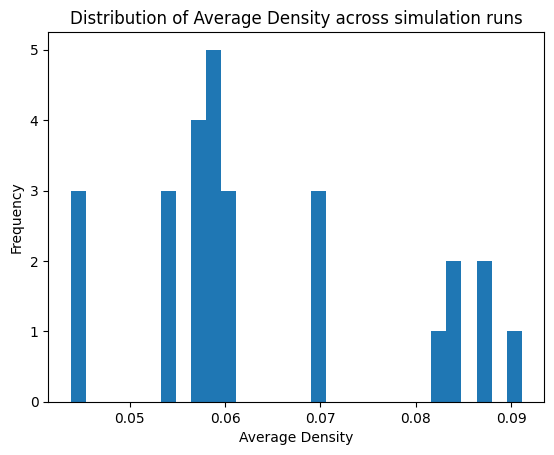

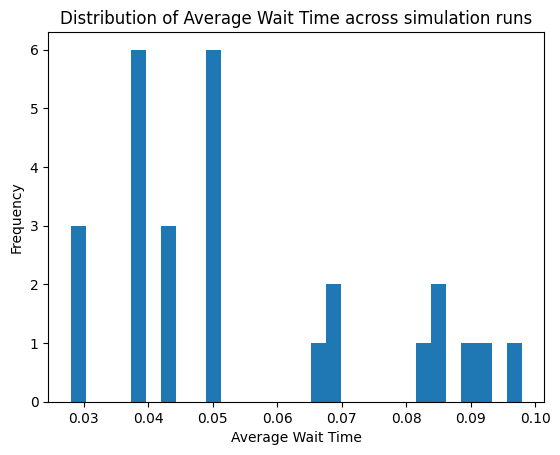

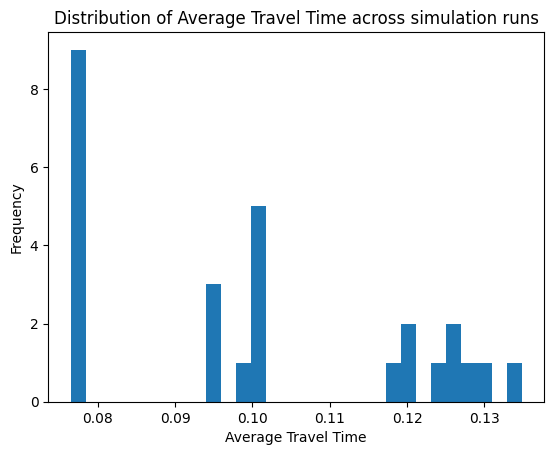

In [167]:
plot_histogram(metrics['avg_dens_mean'], 'Average Density')
plot_histogram(metrics['avg_w_time_mean'], 'Average Wait Time')
plot_histogram(metrics['avg_travel_mean'], 'Average Travel Time')

#### Layout 2: Simple rectangular block

In [141]:
# The layout establishes the number of lanes, their positions, and their directions so should remain constant for each experiment
layout2 = {'N': [30],
        'S': [10],
        'E': [15],
        'W': [35]}
# Lists of values to test for each parameter
priority_values2 = [{'N':2, 'S':2, 'E':2, 'W':2}, # Equal priority for all lanes
                   {'N':3, 'S':3, 'E':1, 'W':1}, # Prioritize vertical lanes
                   {'N':1, 'S':1, 'E':3, 'W':3}, # Prioritize horizontal lanes
                   {'N':3, 'S':4, 'E':1, 'W':1}, # Prioritize central southbound lanes, horizontal lanes have lowest priority
                   {'N':1, 'S':4, 'E':3, 'W':3}] # Prioritize central southbound lanes, then horizontal lanes
schema_values2 = ['default', 'staggered']
entry_rate_values2 = [0.1, 0.3, 0.6]

# Initialize empty lists for each metric and parameter
avg_car_density2 = []
max_car_density2 = []
max_waiting_cars2 = []
avg_waiting_time2 = []
avg_travel_time2 = []
priority2 = []
schema2 = []
entry_rate2 = []

# Run the each experiment, appending the metrics and parameters to the lists
for p in priority_values2:
    for s in schema_values2:
        if s == 'staggered' and len(set(p.values())) == 1:
            continue
        for e in entry_rate_values2:
            _, results = run_experiment(n_runs=100, size=50, timesteps=400, layout=layout2, priority=p, schema=s, entry_rate=e)
            avg_car_density2.append(results['average_car_density'])
            max_car_density2.append(results['maximum_car_density'])
            max_waiting_cars2.append(results['maximum_waiting_cars'])
            avg_waiting_time2.append(results['average_waiting_time'])
            avg_travel_time2.append(results['average_travel_time'])
            priority2.append(p)
            schema2.append(s)
            entry_rate2.append(e)

In [142]:
# Combine lists into a dictionary
metrics2 = pd.DataFrame({
    'schema': schema2,
    'e_r': entry_rate2,
    'priority': priority2,
    'avg_dens': avg_car_density2,
    'max_dens': max_car_density2,
    'max_w_cars': max_waiting_cars2,
    'avg_w_time': avg_waiting_time2,
    'avg_travel': avg_travel_time2
})

# Cleaning stuff up a bit for readability, replace nested tuples with mean
for col in list(metrics2.columns):
    if col == 'priority':
        metrics2[col] = metrics2[col].apply(lambda x: '-'.join([f'{k}:{v}' for k,v in x.items()]))
    # Only look at the metrics columns
    if col.startswith(('avg', 'max')):
        rounded_means = []
        rounded_conf_intervals = []
        # Iterate over each value and round mean and ci to 4 decimals
        for mean, conf_interval in metrics2[col]:
            rounded_means.append(round(mean, 4))
            rounded_conf_intervals.append(tuple(round(x, 4) for x in conf_interval))
        # Add column with the rounded means and confidence intervals
        metrics2[f'{col}_mean'] = rounded_means
        metrics2[f'{col}_ci'] = rounded_conf_intervals
        # Remove old column
        metrics2.drop(columns=col, inplace=True)

# Define lists of columns for average and maximum metrics
min_cols2 = [col for col in metrics2.columns if ('avg' in col or 'max' in col) and '_mean' in col]

# Initialize an empty DataFrame to store the best rows
best_rows2 = pd.DataFrame()

# For each metric, find the row with the minimum value for each entry_rate
for col in min_cols:
    min_rows = metrics2.loc[metrics2.groupby('e_r')[col].idxmin()]
    best_rows = pd.concat([best_rows, min_rows])
    best_rows[col] = best_rows[col].apply(lambda x: f'* {x}')
clean_best_rows2 = best_rows.drop_duplicates(subset=['e_r', 'schema', 'priority'])

# Sort best priority and schema for each entry rate
clean_best_rows2.sort_values(by='e_r')

,schema,e_r,priority,avg_dens_mean,avg_dens_ci,max_dens_mean,max_dens_ci,max_w_cars_mean,max_w_cars_ci,avg_w_time_mean,avg_w_time_ci,avg_travel_mean,avg_travel_ci
0,default,0.1,N:2-S:2-E:2-W:2,* * 0.0438,"(0.0438, 0.0438)",* * 0.0765,"(0.0765, 0.0765)",* * 4.72,"(4.7159, 4.7241)",* * 0.028,"(0.028, 0.0281)",* * 0.077,"(0.077, 0.0771)"
21,default,0.1,N:1-S:4-E:3-W:3,* 0.0598,"(0.0598, 0.0598)",* 0.0983,"(0.0983, 0.0984)",* 6.7,"(6.6938, 6.7062)",* 0.0387,"(0.0387, 0.0387)",* * 0.0765,"(0.0765, 0.0765)"
1,default,0.3,N:2-S:2-E:2-W:2,* * 0.0443,"(0.0443, 0.0444)",* * 0.0765,"(0.0765, 0.0765)",* * 4.89,"(4.8849, 4.8951)",* * 0.0283,"(0.0283, 0.0283)",* * 0.0772,"(0.0772, 0.0772)"
25,staggered,0.3,N:1-S:4-E:3-W:3,* 0.059,"(0.059, 0.0591)",* 0.0999,"(0.0998, 0.1)",* 7.07,"(7.0637, 7.0763)",* 0.0389,"(0.0389, 0.0389)",* * 0.077,"(0.077, 0.077)"
22,default,0.3,N:1-S:4-E:3-W:3,0.053,"(0.0529, 0.053)",0.0969,"(0.0968, 0.097)",6.63,"(6.624, 6.636)",0.0657,"(0.0656, 0.0657)",* 0.1376,"(0.1375, 0.1376)"
2,default,0.6,N:2-S:2-E:2-W:2,* * 0.044,"(0.044, 0.044)",* * 0.0766,"(0.0766, 0.0766)",* * 4.84,"(4.8346, 4.8454)",* * 0.0283,"(0.0283, 0.0283)",* * 0.0771,"(0.0771, 0.0771)"
26,staggered,0.6,N:1-S:4-E:3-W:3,* 0.0597,"(0.0596, 0.0597)",* 0.1005,"(0.1004, 0.1005)",* 7.04,"(7.0323, 7.0477)",* 0.0388,"(0.0388, 0.0388)",* * 0.0767,"(0.0767, 0.0768)"
23,default,0.6,N:1-S:4-E:3-W:3,0.0529,"(0.0529, 0.0529)",0.097,"(0.097, 0.0971)",6.69,"(6.6823, 6.6977)",0.0639,"(0.0638, 0.0639)",* 0.1355,"(0.1354, 0.1355)"


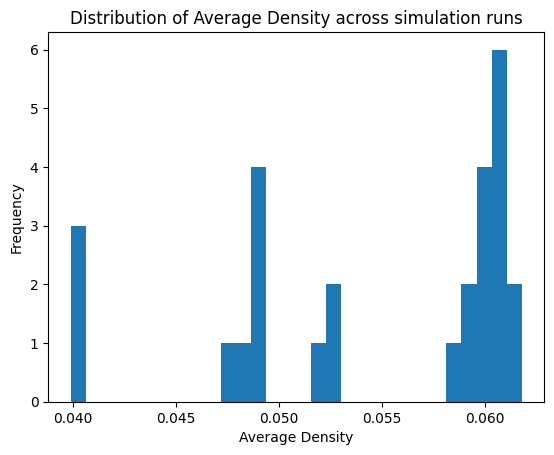

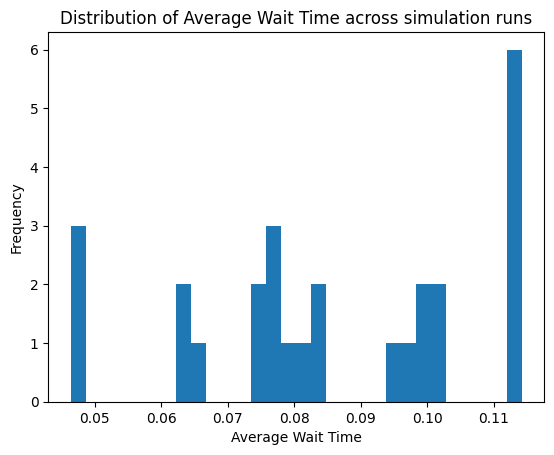

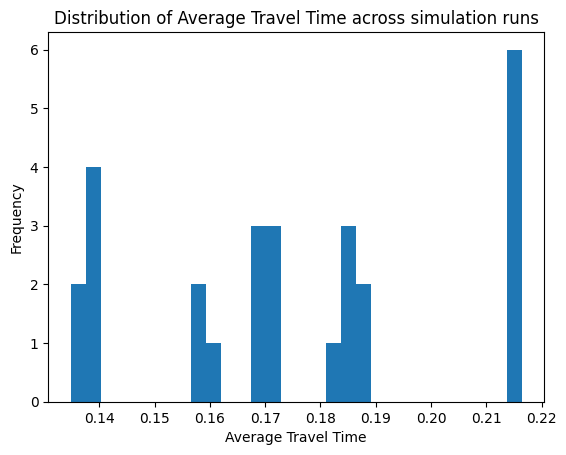

In [168]:
plot_histogram(metrics2['avg_dens_mean'], 'Average Density')
plot_histogram(metrics2['avg_w_time_mean'], 'Average Wait Time')
plot_histogram(metrics2['avg_travel_mean'], 'Average Travel Time')